# Scraping Script

Processing the scraped data is further below

In [1]:
import asyncio
import nest_asyncio
import csv
import datetime
from dotenv import load_dotenv
import os

from telethon import TelegramClient, events, sync
from telethon.tl.functions.messages import GetHistoryRequest
import pandas as pd

import numpy as np
import pandas as pd
import re

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# for the data labelling, comment out if not used
from tqdm.notebook import tqdm
import ollama

from pydantic import BaseModel, Field, ValidationError
from typing import Dict, List, Literal

In [87]:
load_dotenv()
api_id = os.getenv("TELE_API") 
api_hash = os.getenv("TELE_HASH")
session_name = 'tele_scrape_btc'

nest_asyncio.apply()

For reference, these are the channel names, handles and IDs

IDs may differ between users so the handles are provided here for reproducibility

* Channel Name: Crypto Pump Club 📈, Tele Handle: cryptoclubpump
* Channel Name: Binance Killers®, Tele Handle: binancekillers
* Channel Name: Technical CRYPTO Analyst, Tele Handle: TechCryptoAnalyst
* Channel Name: Fed. Russian Insiders®, Tele Handle: FedRussianInsiders
* Channel Name: Wallstreet Queen Official®, Tele Handle: wallstreetqueenofficial
* Channel Name: Whales Crypto Guide, Tele Handle: Whalesguide

In [88]:
chat_names = ["Crypto Pump Club", "Binance Killers", "Wallstreet Queen Official", "Technical CRYPTO Analyst", "Whales Crypto Guide", "Fed. Russian Insiders"]

In [89]:
chats = {}
async def find_channel(channel_names):
    """ Function to find the correct ID of channel or group chats

    Args:
        channel_names (list(str)): list of strings of partial channel names to search for
    
    Outputs:
        prints matched channels with their IDs
    """
    
    async with TelegramClient(session_name, api_id, api_hash) as client:
        
        dialogs = await client.get_dialogs()
        channels = [dialog for dialog in dialogs if dialog.is_channel]

        for channel in channels:
            if any(channel_name.lower() in channel.name.lower() for channel_name in channel_names):
                print(f"{channel.name} found with id: {channel.entity.id}, username: {channel.entity.username}")
                chats[channel.name] = [channel.entity.id, channel.entity.username]

asyncio.run(find_channel(chat_names))


Crypto Pump Club 📈 found with id: 1625691880, username: cryptoclubpump
Binance Killers® found with id: 1220789766, username: binancekillers
Technical CRYPTO Analyst found with id: 1349397698, username: TechCryptoAnalyst
Fed. Russian Insiders® found with id: 1317169843, username: FedRussianInsiders
Wallstreet Queen Official® found with id: 1347728413, username: wallstreetqueenofficial
Whales Crypto Guide found with id: 1288385100, username: Whalesguide


In [90]:
for name, data in chats.items():
    print(f"Channel Name: {name}, Tele Handle: {data[1]}")
    print(f"ID: {data[0]}", end="\n\n")

Channel Name: Crypto Pump Club 📈, Tele Handle: cryptoclubpump
ID: 1625691880

Channel Name: Binance Killers®, Tele Handle: binancekillers
ID: 1220789766

Channel Name: Technical CRYPTO Analyst, Tele Handle: TechCryptoAnalyst
ID: 1349397698

Channel Name: Fed. Russian Insiders®, Tele Handle: FedRussianInsiders
ID: 1317169843

Channel Name: Wallstreet Queen Official®, Tele Handle: wallstreetqueenofficial
ID: 1347728413

Channel Name: Whales Crypto Guide, Tele Handle: Whalesguide
ID: 1288385100



In [ ]:
async def fetch_messages():
    df = pd.DataFrame(columns=["channel", "text", "date"])
    earliest_msg = datetime.datetime(2024, 1, 1) # March 1st as temporary testing
    async with TelegramClient(session_name, api_id, api_hash) as client:
        await client.start()
        for _, (channel_id, channel_handle) in chats.items():
            
            channel = await client.get_entity(channel_id)
            print(channel.title)
            messages = []
            async for message in client.iter_messages(channel, reverse=True, offset_date=earliest_msg, limit=None): # adjust limit as necessary
                messages.append({
                    "channel": channel_handle,
                    #"sender": int(message.sender_id),
                    "text": message.text,
                    "date": message.date
                }) 
            df = pd.concat([df, pd.DataFrame(messages)], ignore_index=True)
        df.to_csv("../data/raw/tele_channel_messages.csv", encoding="utf-8-sig", index=False)

asyncio.run(fetch_messages())

Crypto Pump Club 📈


C:\Users\chewy\AppData\Local\Temp\ipykernel_30908\154518636.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(messages)], ignore_index=True)


Binance Killers®
Technical CRYPTO Analyst
Fed. Russian Insiders®
Wallstreet Queen Official®
Whales Crypto Guide


# Cleaning up data

In [2]:
df = pd.read_csv(r"../data/raw/tele_channel_messages.csv")

In [3]:
print(df.isna().sum())
df = df.dropna()
print(df.info())

channel      0
sender       0
text       447
date         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 17747 entries, 0 to 18193
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   channel  17747 non-null  object
 1   sender   17747 non-null  int64 
 2   text     17747 non-null  object
 3   date     17747 non-null  object
dtypes: int64(1), object(3)
memory usage: 693.2+ KB
None


In [4]:
df = df.drop(columns=["sender"], axis=0)
df.head()

,channel,text,date
0,cryptoclubpump,**HAPPY NEW YEAR ❤️\n\n**We vow to provide you...,2024-01-01 14:13:15+00:00
1,cryptoclubpump,We’re planning our next pump for this Sunday. ...,2024-01-01 14:14:15+00:00
2,cryptoclubpump,‼️ **MAJOR** **PUMP ANNOUNCEMENT **‼️\n\nHere’...,2024-01-02 13:48:18+00:00
3,cryptoclubpump,**‼️ 5 DAYS UNTIL THE PUMP ON MEXC**,2024-01-02 15:00:49+00:00
4,cryptoclubpump,**‼️ 4 DAYS UNTIL THE PUMP ON MEXC\n\n**In jus...,2024-01-03 15:00:04+00:00


In [5]:
df = df.dropna(subset=['channel']).reset_index(drop=True)
encoder = OneHotEncoder(sparse=False, drop=None)
encoded_senders = encoder.fit_transform(df[['channel']])
encoded_df = pd.DataFrame(encoded_senders, columns=encoder.get_feature_names_out(['channel']), index=df.index)
df = df.drop(columns=['channel']) 
df = pd.concat([df, encoded_df], axis=1) 

In [6]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
        text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove non-ASCII characters (emojis)
    return text

df["text"] = df["text"].apply(clean_text)

In [7]:
df.head()

,text,date,channel_FedRussianInsiders,channel_TechCryptoAnalyst,channel_Whalesguide,channel_binancekillers,channel_cryptoclubpump,channel_wallstreetqueenofficial
0,**HAPPY NEW YEAR **We vow to provide you with...,2024-01-01 14:13:15+00:00,0.0,0.0,0.0,0.0,1.0,0.0
1,Were planning our next pump for this Sunday. W...,2024-01-01 14:14:15+00:00,0.0,0.0,0.0,0.0,1.0,0.0
2,**MAJOR** **PUMP ANNOUNCEMENT ** Heres the de...,2024-01-02 13:48:18+00:00,0.0,0.0,0.0,0.0,1.0,0.0
3,** 5 DAYS UNTIL THE PUMP ON MEXC**,2024-01-02 15:00:49+00:00,0.0,0.0,0.0,0.0,1.0,0.0
4,** 4 DAYS UNTIL THE PUMP ON MEXC **In just fou...,2024-01-03 15:00:04+00:00,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
# keywords, if we can have a moderately fast method to assess reliably if news affects btc or bitcoin like crypto outlook, will be even better
keywords = ['bitcoin', 'btc']
df = df[df['text'].str.contains('|'.join(keywords), case=False, na=False)]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3948 entries, 173 to 17745
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   text                             3948 non-null   object 
 1   date                             3948 non-null   object 
 2   channel_FedRussianInsiders       3948 non-null   float64
 3   channel_TechCryptoAnalyst        3948 non-null   float64
 4   channel_Whalesguide              3948 non-null   float64
 5   channel_binancekillers           3948 non-null   float64
 6   channel_cryptoclubpump           3948 non-null   float64
 7   channel_wallstreetqueenofficial  3948 non-null   float64
dtypes: float64(6), object(2)
memory usage: 277.6+ KB


In [10]:
# remove duplicates
orig_size = df.shape[0]
df = df.drop_duplicates(subset=["text"])

print(f"Dataset size after removing duplicates from {orig_size} to {df.shape[0]}")

Dataset size after removing duplicates from 3948 to 3298


In [11]:
# remove short sentences
orig_size = df.shape[0]
df['words'] = [len(x.split()) for x in df['text'].tolist()]
df = df[df["words"] > 5 ]
df = df[df["words"] < 256]
df = df.drop(columns=["words"])

print(f"Dataset size after filtering from {orig_size} to {df.shape[0]}")

Dataset size after filtering from 3298 to 3240


In [115]:
df.to_csv(r"../data/processed/tele_messages_processed.csv")

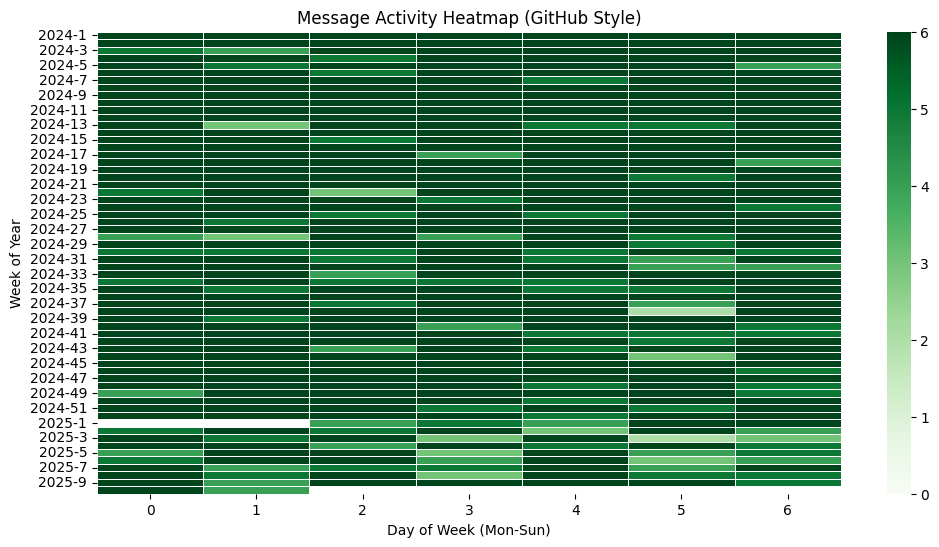

In [12]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.isocalendar().week
df['day'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6

heatmap_data = df.groupby(['year', 'week', 'day']).size().unstack()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="Greens", linewidths=0.5, linecolor="white", vmin=0, vmax=6)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Message Activity Heatmap (GitHub Style)")

plt.show()

just take note here that first 2 days of 2025 has no news

In [13]:
# df = pd.read_csv(r"../data/processed/tele_messages_processed.csv")
class Sentiment(BaseModel):
    """ Sentiment of Bitcoin outlook from the financial news"""
    sentiment: Literal["positive", "negative", "neutral"]

    @classmethod
    def from_response(cls, response: str):
        """Parse and validate response from Ollama"""
        try:
            normalized_response = response.strip().lower()  
            if normalized_response not in {"positive", "negative", "neutral"}:
                raise ValueError(f"Unexpected sentiment: {normalized_response}")
            return cls(sentiment=normalized_response)
        except (ValidationError, ValueError) as e:
            print(f"Error parsing response: {e}; Response: {response}")
            return cls(sentiment="neutral")  # fallback to neutral

In [14]:
model_name = "llama3.1:8b"
def get_sentiment(text):
    prompt = f"""Analyze the sentiment of the following crypto financial text to determine if the outlook on Bitcoin or BTC is positive.
    Text: "{text}"
    
    Provide a single-word label: Positive, Negative, or Neutral.
    Only return the label without additional text.

    Take note that a positive outlook on the crypto market also means that it will result in a positive outlook on Bitcoin and vice versa.
    For example:
    Text:
    Pump into Crypto, market looks good!

    Sentiment: Positive
    """
    
    response = ollama.chat(model=model_name, messages=[{"role": "user", "content": prompt}])
    
    return Sentiment.from_response(response["message"]["content"])

In [15]:
tqdm.pandas()
df["sentiment"] = df["text"].progress_apply(get_sentiment)
df["sentiment"] = df["sentiment"].apply(lambda x: x.sentiment if isinstance(x, Sentiment) else x)

  0%|          | 0/3240 [00:00<?, ?it/s]

Error parsing response: Unexpected sentiment: positive.; Response: Positive.
Error parsing response: Unexpected sentiment: positive.; Response: Positive.
Error parsing response: Unexpected sentiment: neutral.; Response: Neutral.
Error parsing response: Unexpected sentiment: positive.; Response: Positive.
Error parsing response: Unexpected sentiment: neutral.; Response: Neutral.
Error parsing response: Unexpected sentiment: positive.; Response: Positive.
Error parsing response: Unexpected sentiment: positive.; Response: Positive.
Error parsing response: Unexpected sentiment: neutral

reasoning: the sentiment analysis is based on the bitcoin fear and greed index being 77 (extreme greed), which typically indicates a high level of investor confidence. however, the label "fear" rather than "greed" might be more suitable in this context as it suggests a sense of uncertainty or unease among investors due to extremely high levels of greed. nevertheless, since a neutral response is given for th

In [18]:
counts = df["sentiment"].value_counts()
print(counts)
df.to_csv(r"../data/processed/tele_messages_processed_hourly.csv")

sentiment
positive    2261
neutral      574
negative     405
Name: count, dtype: int64


In [16]:
# Viewing sentiments randomly, 10 of each
sampled_texts = df.groupby("sentiment")["text"].apply(lambda x: x.sample(n=10, random_state=42, replace=True)).reset_index()

output_text = ""
for sentiment in ["positive", "negative", "neutral"]:
    output_text += f"\n=== {sentiment.upper()} ===\n"
    if sentiment in sampled_texts["sentiment"].values:
        texts = sampled_texts[sampled_texts["sentiment"] == sentiment]["text"].tolist()
        output_text += "\n".join(f"- {t}" for t in texts)
    else:
        output_text += "No examples found.\n"

print(output_text)


=== POSITIVE ===
- $BTC VIP Analysis January 05, 2024 ------------------- BIAS: Mid-Term: BULLISH Short-Term: BULLISH -------------------- As expected the price action of $BTC successfully showed us the further upward movements after the candle closure above the level and went up towards its 2nd FVG level. Currently, the price action is forming out Double Top pattern level where we can see a short bounce back level before the downward movements -------------------- MAIN INTEREST LEVELS SHORT $44,190 LONG $44,331 PREDICTED DAILY RANGE $45,009 - $42,229 -------------------- VIP ACTION PLAN [VIP EXCLUSIVE CONTENT] -------------------- Yours truly, Federal Russian Insiders
- $BTC VIP Analysis AUGUST 24th, 2024 ------------------- BIAS: Mid-Term: BULLISH Short-Term: BULLISH -------------------- The price action, after retesting and holding the support region, is showing potential movement towards squeezing out the upper side liquidity level.  On the daily timeframe, the price action has al

In [17]:
df = pd.read_csv(r"../data/processed/tele_messages_processed_hourly.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/tele_messages_processed_hourly.csv'

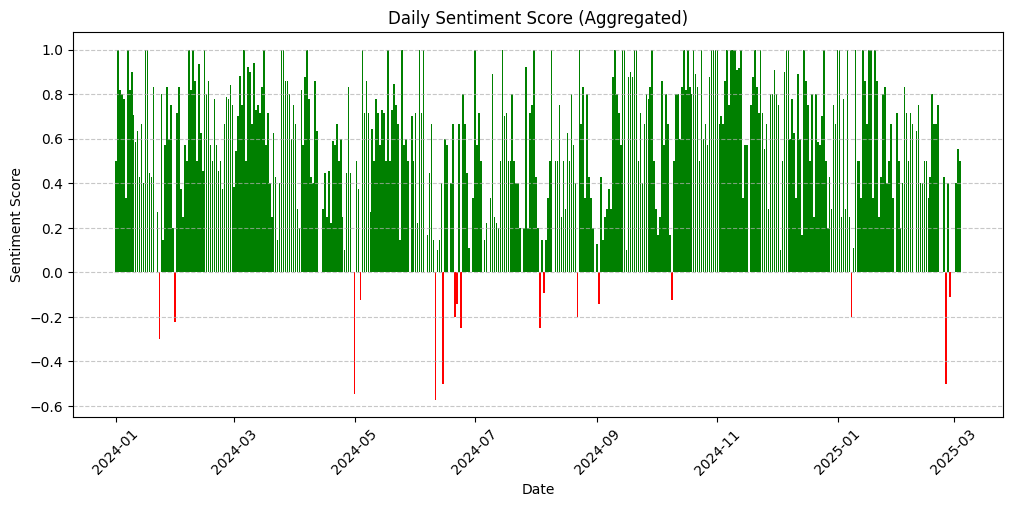

In [ ]:

# df["date"] = pd.to_datetime(df["date"]).dt.date  # Keep only the date part

# Map sentiment values to numerical scores
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

# Aggregate sentiment scores per day
daily_sentiment = df.groupby("date")["sentiment_score"].mean()

# Plot sentiment over time (GitHub-style heatmap)
plt.figure(figsize=(12, 5))
plt.bar(daily_sentiment.index, daily_sentiment.values, color=np.where(daily_sentiment > 0, 'green', 'red'))

plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Daily Sentiment Score (Aggregated)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()



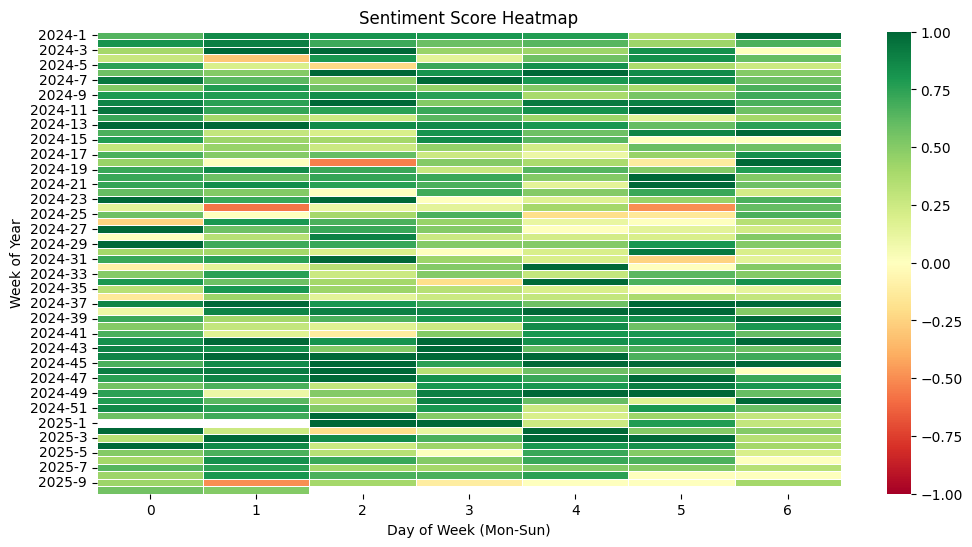

In [32]:
df["date"] = pd.to_datetime(df["date"])

# Map sentiment values to numerical scores
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

df["year"] = df["date"].dt.year
df["week"] = df["date"].dt.isocalendar().week
df["day"] = df["date"].dt.dayofweek  

heatmap_data = df.groupby(["year", "week", "day"])["sentiment_score"].mean().unstack()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="RdYlGn", linewidths=0.5, linecolor="white", center=0, vmin=-1, vmax=1)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Sentiment Score Heatmap")
plt.show()


# Creating Decaying scores

Linear and Weibull distribution
Based on ethans code in "reddit_preprocess.ipynb"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
folder_path = '../data/processed/'

In [5]:
tele_messages_path = os.path.join(folder_path, 'tele_messages_processed_hourly_2803.csv')
tele_messages = pd.read_csv(tele_messages_path, index_col=0).reset_index()
tele_messages = tele_messages.rename(columns = {'index': 'date'})

# Convert DATE column to datetime format
tele_messages['date'] = pd.to_datetime(tele_messages['date'])
tele_messages = tele_messages.sort_values(by='date').reset_index(drop = True)

df = tele_messages.copy()

In [7]:
df.drop(columns=['smoothed_sentiment', 'smoothed_sentiment_weibull'], inplace=True)

In [10]:
df

,date,text,channel_FedRussianInsiders,channel_TechCryptoAnalyst,channel_Whalesguide,channel_binancekillers,channel_cryptoclubpump,channel_wallstreetqueenofficial,year,week,day,sentiment,sentiment_score
0,2024-01-01 06:00:00+00:00,"**January 1, 2024 MARKET ANALYSIS:** Market C...",0.0,0.0,0.0,1.0,0.0,0.0,2024,1,0,positive,1
1,2024-01-01 11:00:00+00:00,"$BTC VIP Analysis January 01, 2024 -----------...",1.0,0.0,0.0,0.0,0.0,0.0,2024,1,0,positive,1
2,2024-01-01 15:00:00+00:00,**$BTC**** DOMINANCE UPDATE VIP --------------...,1.0,0.0,0.0,0.0,0.0,0.0,2024,1,0,positive,1
3,2024-01-01 20:00:00+00:00,**$SEI**** update !!! +67.44% profit in btc pa...,0.0,0.0,1.0,0.0,0.0,0.0,2024,1,0,positive,1
4,2024-01-01 20:00:00+00:00,$GMT **update !!! +19.02% profit in btc pairin...,0.0,0.0,1.0,0.0,0.0,0.0,2024,1,0,positive,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3391,2025-03-28 02:00:00+00:00,**UPDATE VIP** **------------------- ******** ...,1.0,0.0,0.0,0.0,0.0,0.0,2025,13,4,negative,-1
3392,2025-03-28 05:00:00+00:00,**#BTC****/USDT UPDATE:** Bitcoin has been tra...,0.0,0.0,0.0,0.0,0.0,1.0,2025,13,4,negative,-1
3393,2025-03-28 06:00:00+00:00,The U.S. government transferred approximately ...,0.0,0.0,0.0,0.0,0.0,1.0,2025,13,4,neutral,0
3394,2025-03-28 07:00:00+00:00,"**March 28, 2025 MARKET ANALYSIS:** Market Ca...",0.0,0.0,0.0,1.0,0.0,0.0,2025,13,4,neutral,0


In [9]:
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

In [11]:
df = df.rename(columns={'date': 'created_at'})

C:\Users\Justin\AppData\Local\Temp\ipykernel_16172\22239851.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_time = df['created_at'].min().floor('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_16172\22239851.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_time = df['created_at'].max().ceil('H')
C:\Users\Justin\AppData\Local\Temp\ipykernel_16172\22239851.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                           smoothed_sentiment
2024-01-01 06:00:00+00:00            1.000000
2024-01-01 07:00:00+00:00            0.958333
2024-01-01 08:00:00+00:00            0.916667
2024-01-01 09:00:00+00:00            0.875000
2024-01-01 10:00:00+00:00            0.833333


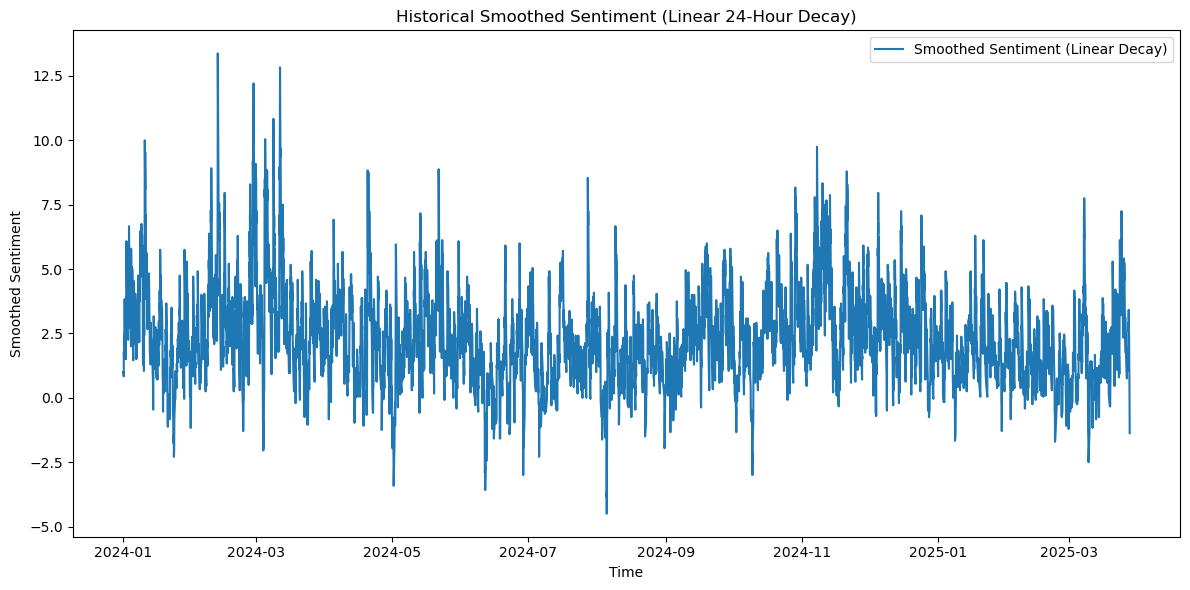

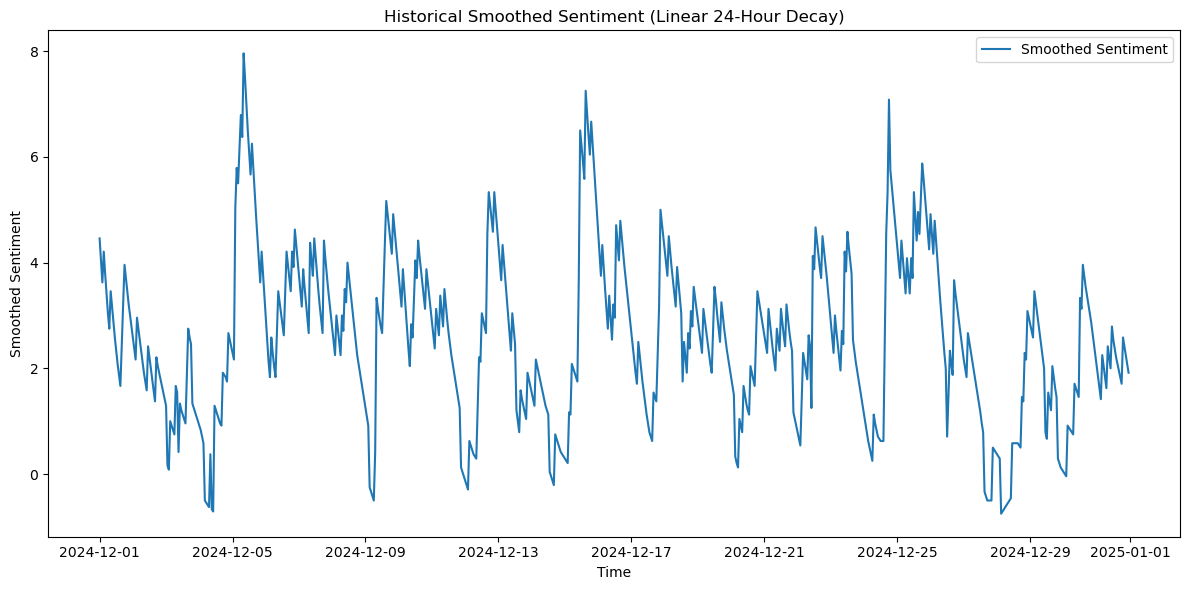

In [12]:
df['created_at'] = pd.to_datetime(df['created_at'])

# Define the start and end time for the analysis (rounded to the nearest hour)
start_time = df['created_at'].min().floor('H')
end_time = df['created_at'].max().ceil('H')

# Create an hourly date range
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_linear(t):
    """
    Compute the smoothed sentiment at time t as the weighted sum of sentiment scores
    in the past 24 hours. Each news event decays linearly: its weight is 
    1 - (time difference in hours)/24.
    """
    # Define the 24-hour window for events affecting time t
    window_start = t - pd.Timedelta(hours=24)
    
    # Filter news events that occurred in the last 24 hours (excluding events after t)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    
    if df_window.empty:
        return 0.0  # No news, no sentiment effect.
    
    # Calculate the time difference (in hours) between t and each news event
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Linear decay: weight = 1 - (difference/24)
    weights = 1 - (time_diffs / 24)
    weights = weights.clip(lower=0)  # Ensure no negative weights
    
    # Compute the weighted sentiment sum
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# Apply the function to each timestamp in the hourly index
smoothed_sentiments = [compute_smoothed_sentiment_linear(t) for t in hourly_index]

# Create a DataFrame with the results
df_sentiment = pd.DataFrame({'smoothed_sentiment': smoothed_sentiments}, index=hourly_index)

# Display the first few rows
print(df_sentiment.head())

# Optionally, plot the smoothed sentiment time series 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment'], label='Smoothed Sentiment (Linear Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment'], label='Smoothed Sentiment')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Linear 24-Hour Decay)')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\Justin\AppData\Local\Temp\ipykernel_16172\4097292014.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                           smoothed_sentiment  smoothed_sentiment_weibull
2024-01-01 06:00:00+00:00            1.000000                    0.000000
2024-01-01 07:00:00+00:00            0.958333                    0.377961
2024-01-01 08:00:00+00:00            0.916667                    0.695482
2024-01-01 09:00:00+00:00            0.875000                    0.907943
2024-01-01 10:00:00+00:00            0.833333                    0.996670


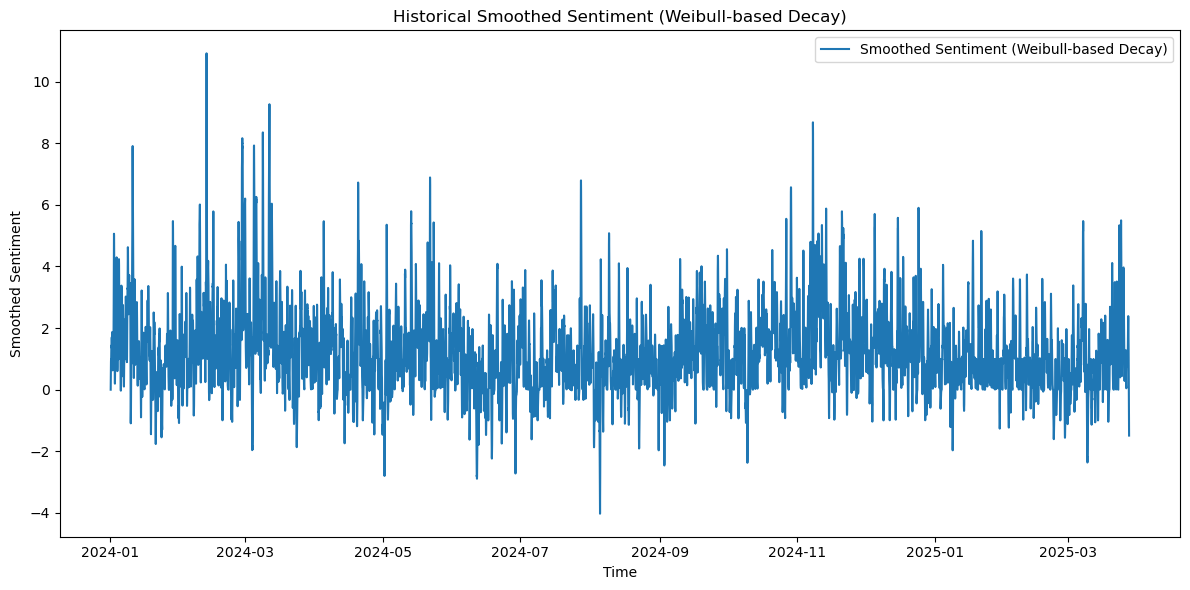

In [13]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt


# Parameters for the Weibull distribution
k = 2.0       # shape parameter (k > 1 gives a peak)
lam = 6.0     # scale parameter in hours (peak attention around ~4.24 hours)
# Determine the mode (peak) of the Weibull PDF and compute its maximum value
x_mode = lam * ((k - 1) / k) ** (1 / k)
max_weight = weibull_min.pdf(x_mode, k, scale=lam)

def weight_function(x):
    """Compute the weight for elapsed time x (in hours) using the Weibull PDF normalized to 1."""
    if x < 0:
        return 0.0
    return weibull_min.pdf(x, k, scale=lam) / max_weight

# Create an hourly date range for the smoothed sentiment time series
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

def compute_smoothed_sentiment_weibull(t):
    """
    Compute the smoothed sentiment at time t by summing the weighted sentiment scores
    from news events in the last 48 hours.
    """
    # Consider news events from the past 48 hours
    window_start = t - pd.Timedelta(hours=48)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    if df_window.empty:
        return 0.0
    # Compute elapsed time in hours from each news event to time t
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Calculate weights for each news event using the Weibull function
    weights = time_diffs.apply(weight_function)
    # Compute the weighted sum of sentiment scores
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# Compute the smoothed sentiment for each hour in the time series
smoothed_sentiments = [compute_smoothed_sentiment_weibull(t) for t in hourly_index]
df_sentiment['smoothed_sentiment_weibull'] = smoothed_sentiments

# Display the first few rows
print(df_sentiment.head())

# Plot the smoothed sentiment over time
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull'], label='Smoothed Sentiment (Weibull-based Decay)')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

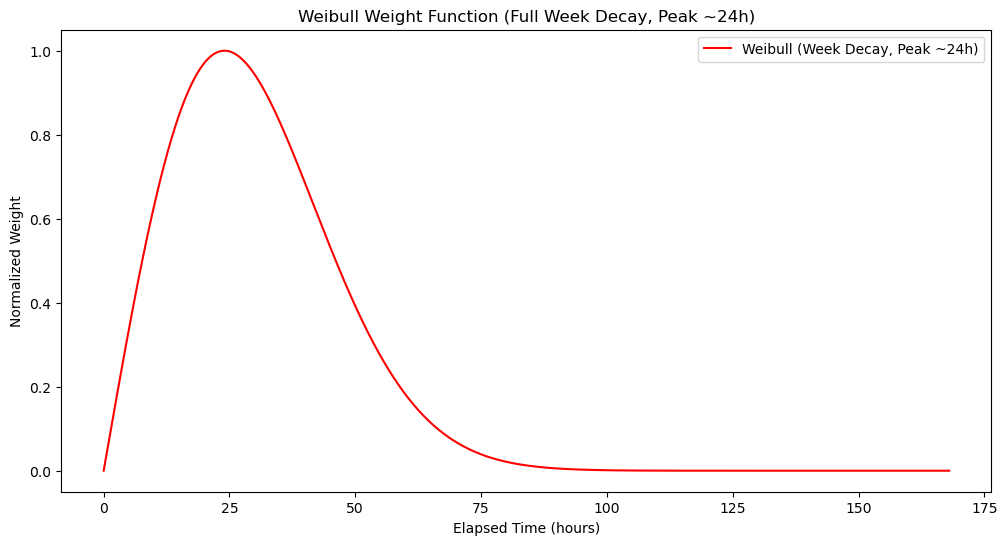

C:\Users\Justin\AppData\Local\Temp\ipykernel_16172\3278704075.py:61: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')


                           smoothed_sentiment  smoothed_sentiment_weibull  \
2024-01-01 06:00:00+00:00            1.000000                    0.000000   
2024-01-01 07:00:00+00:00            0.958333                    0.377961   
2024-01-01 08:00:00+00:00            0.916667                    0.695482   
2024-01-01 09:00:00+00:00            0.875000                    0.907943   
2024-01-01 10:00:00+00:00            0.833333                    0.996670   

                           smoothed_sentiment_weibull_week  
2024-01-01 06:00:00+00:00                         0.000000  
2024-01-01 07:00:00+00:00                         0.068637  
2024-01-01 08:00:00+00:00                         0.136917  
2024-01-01 09:00:00+00:00                         0.204486  
2024-01-01 10:00:00+00:00                         0.270997  


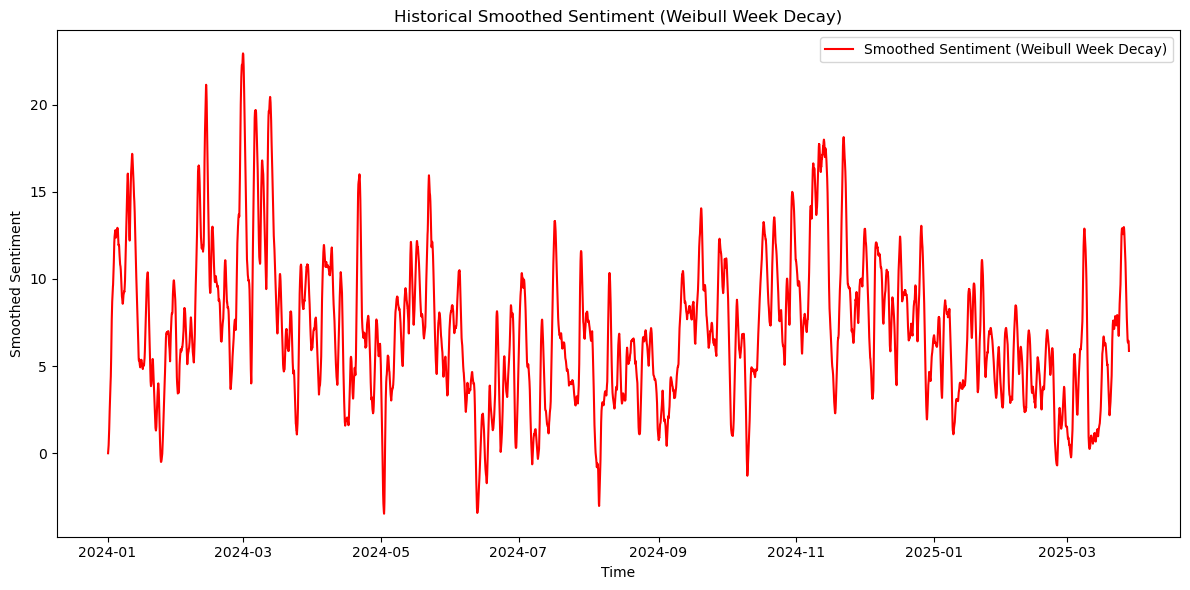

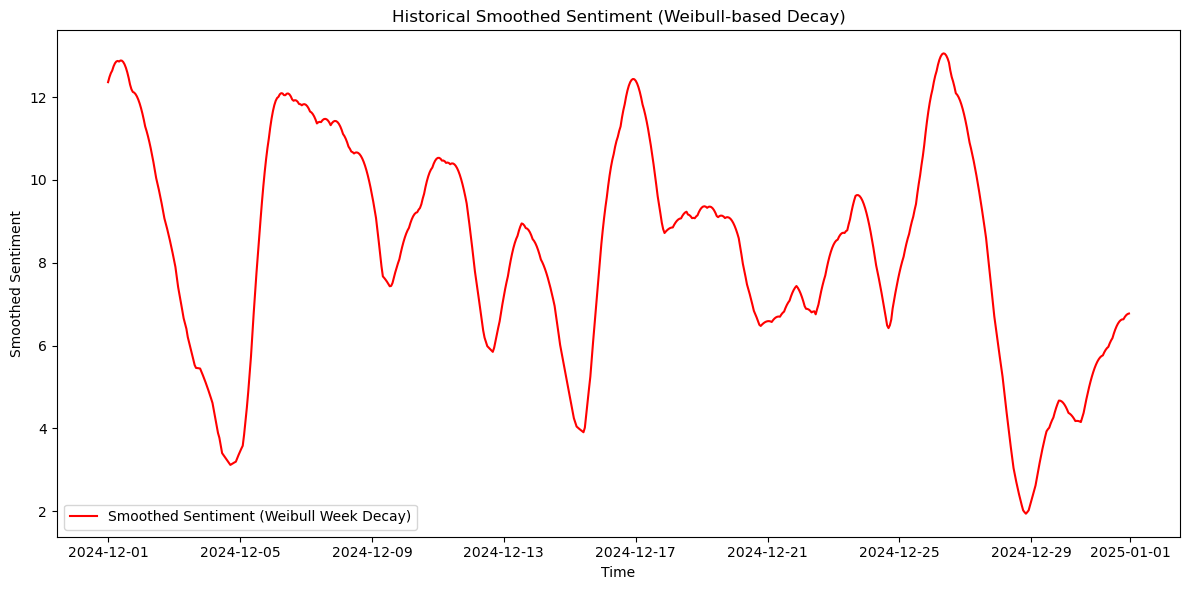

In [16]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
import numpy as np

# --- Alternative Weibull Parameters for a Full Week Decay ---
# We want the mode (peak) to be ~24 hours. For a Weibull with shape k,
# the mode is given by: mode = lam * ((k-1)/k)^(1/k)
# For k = 2.0, set lam such that lam/sqrt(2) = 24 => lam = 24 * sqrt(2)
k_week = 2.0
lam_week = 24 * np.sqrt(2)   # Approximately 33.94 hours
x_mode_week = lam_week * ((k_week - 1) / k_week) ** (1 / k_week)
max_weight_week = weibull_min.pdf(x_mode_week, k_week, scale=lam_week)

def weight_function_week(x):
    """
    Compute the weight for an elapsed time x (in hours) using a Weibull PDF 
    normalized so that the maximum weight is 1.
    
    This function is designed so that the impact of a post increases to a peak 
    around 24 hours and then decays over the course of one week (168 hours).
    """
    if x < 0:
        return 0.0
    return weibull_min.pdf(x, k_week, scale=lam_week) / max_weight_week

# --- For Comparison: Plot the Weight Function ---
x_vals = np.linspace(0, 168, 500)  # from 0 to 168 hours
y_vals = [weight_function_week(x) for x in x_vals]

plt.figure(figsize=(12,6))
plt.plot(x_vals, y_vals, label='Weibull (Week Decay, Peak ~24h)', color='red')
plt.xlabel('Elapsed Time (hours)')
plt.ylabel('Normalized Weight')
plt.title('Weibull Weight Function (Full Week Decay, Peak ~24h)')
plt.legend()
plt.show()

# --- Alternative Smoothed Sentiment Function Using the New Weight Function ---
def compute_smoothed_sentiment_weibull_week(t):
    """
    Compute the smoothed sentiment at time t by summing the weighted sentiment scores
    from news events in the last week (168 hours) using the alternative Weibull function.
    """
    # Consider news events in the last 168 hours (1 week)
    window_start = t - pd.Timedelta(hours=168)
    df_window = df[(df['created_at'] > window_start) & (df['created_at'] <= t)]
    if df_window.empty:
        return 0.0
    # Calculate the elapsed time in hours since each post
    time_diffs = (t - df_window['created_at']).dt.total_seconds() / 3600.0
    # Apply the alternative Weibull weight function
    weights = time_diffs.apply(weight_function_week)
    # Sum the weighted sentiment scores
    weighted_sentiment = (df_window['sentiment_score'] * weights).sum()
    return weighted_sentiment

# --- Assuming you have start_time, end_time, and df defined ---
# For example, if:
# start_time = df['created_at'].min().floor('H')
# end_time = df['created_at'].max().ceil('H')
hourly_index = pd.date_range(start=start_time, end=end_time, freq='H')

# Compute the smoothed sentiment using the alternative function
smoothed_sentiments_week = [compute_smoothed_sentiment_weibull_week(t) for t in hourly_index]

# Save results in a DataFrame for further analysis/plotting
df_sentiment['smoothed_sentiment_weibull_week'] = smoothed_sentiments_week
print(df_sentiment.head())

plt.figure(figsize=(12,6))
plt.plot(df_sentiment.index, df_sentiment['smoothed_sentiment_weibull_week'], label='Smoothed Sentiment (Weibull Week Decay)', color='red')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull Week Decay)')
plt.legend()
plt.tight_layout()
plt.show()

#plot a section of the data from  2024-11 to 2024-12
plt.figure(figsize=(12,6))
plt.plot(df_sentiment.loc['2024-12':'2024-12'].index, df_sentiment.loc['2024-12':'2024-12']['smoothed_sentiment_weibull_week'], label='Smoothed Sentiment (Weibull Week Decay)', color='red')
plt.xlabel('Time')
plt.ylabel('Smoothed Sentiment')
plt.title('Historical Smoothed Sentiment (Weibull-based Decay)')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
df_sentiment

,smoothed_sentiment,smoothed_sentiment_weibull,smoothed_sentiment_weibull_week
2024-01-01 06:00:00+00:00,1.000000,0.000000,0.000000
2024-01-01 07:00:00+00:00,0.958333,0.377961,0.068637
2024-01-01 08:00:00+00:00,0.916667,0.695482,0.136917
2024-01-01 09:00:00+00:00,0.875000,0.907943,0.204486
2024-01-01 10:00:00+00:00,0.833333,0.996670,0.270997
...,...,...,...
2025-03-28 03:00:00+00:00,1.041667,0.646805,6.379600
2025-03-28 04:00:00+00:00,0.916667,0.024594,6.298000
2025-03-28 05:00:00+00:00,-0.208333,-0.430358,6.208779
2025-03-28 06:00:00+00:00,-0.291667,-1.075539,6.043296


In [20]:
df = tele_messages.copy()
df.drop(columns=['smoothed_sentiment', 'smoothed_sentiment_weibull'], inplace=True)

In [21]:
df

,date,text,channel_FedRussianInsiders,channel_TechCryptoAnalyst,channel_Whalesguide,channel_binancekillers,channel_cryptoclubpump,channel_wallstreetqueenofficial,year,week,day,sentiment
0,2024-01-01 06:00:00+00:00,"**January 1, 2024 MARKET ANALYSIS:** Market C...",0.0,0.0,0.0,1.0,0.0,0.0,2024,1,0,positive
1,2024-01-01 11:00:00+00:00,"$BTC VIP Analysis January 01, 2024 -----------...",1.0,0.0,0.0,0.0,0.0,0.0,2024,1,0,positive
2,2024-01-01 15:00:00+00:00,**$BTC**** DOMINANCE UPDATE VIP --------------...,1.0,0.0,0.0,0.0,0.0,0.0,2024,1,0,positive
3,2024-01-01 20:00:00+00:00,**$SEI**** update !!! +67.44% profit in btc pa...,0.0,0.0,1.0,0.0,0.0,0.0,2024,1,0,positive
4,2024-01-01 20:00:00+00:00,$GMT **update !!! +19.02% profit in btc pairin...,0.0,0.0,1.0,0.0,0.0,0.0,2024,1,0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...
3391,2025-03-28 02:00:00+00:00,**UPDATE VIP** **------------------- ******** ...,1.0,0.0,0.0,0.0,0.0,0.0,2025,13,4,negative
3392,2025-03-28 05:00:00+00:00,**#BTC****/USDT UPDATE:** Bitcoin has been tra...,0.0,0.0,0.0,0.0,0.0,1.0,2025,13,4,negative
3393,2025-03-28 06:00:00+00:00,The U.S. government transferred approximately ...,0.0,0.0,0.0,0.0,0.0,1.0,2025,13,4,neutral
3394,2025-03-28 07:00:00+00:00,"**March 28, 2025 MARKET ANALYSIS:** Market Ca...",0.0,0.0,0.0,1.0,0.0,0.0,2025,13,4,neutral


In [22]:
df = df.rename(columns={'date': 'datetime'})
df['datetime'] = pd.to_datetime(df['datetime']).dt.floor('H')
df = df.set_index('datetime')
df = df.join(df_sentiment)


C:\Users\Justin\AppData\Local\Temp\ipykernel_16172\2330747170.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['datetime'] = pd.to_datetime(df['datetime']).dt.floor('H')


In [23]:
df

,text,channel_FedRussianInsiders,channel_TechCryptoAnalyst,channel_Whalesguide,channel_binancekillers,channel_cryptoclubpump,channel_wallstreetqueenofficial,year,week,day,sentiment,smoothed_sentiment,smoothed_sentiment_weibull,smoothed_sentiment_weibull_week
2024-01-01 06:00:00+00:00,"**January 1, 2024 MARKET ANALYSIS:** Market C...",0.0,0.0,0.0,1.0,0.0,0.0,2024,1,0,positive,1.000000,0.000000,0.000000
2024-01-01 11:00:00+00:00,"$BTC VIP Analysis January 01, 2024 -----------...",1.0,0.0,0.0,0.0,0.0,0.0,2024,1,0,positive,1.791667,0.970259,0.336110
2024-01-01 15:00:00+00:00,**$BTC**** DOMINANCE UPDATE VIP --------------...,1.0,0.0,0.0,0.0,0.0,0.0,2024,1,0,positive,2.458333,1.365300,0.847288
2024-01-01 20:00:00+00:00,**$SEI**** update !!! +67.44% profit in btc pa...,0.0,0.0,1.0,0.0,0.0,0.0,2024,1,0,positive,3.833333,1.362393,1.723687
2024-01-01 20:00:00+00:00,$GMT **update !!! +19.02% profit in btc pairin...,0.0,0.0,1.0,0.0,0.0,0.0,2024,1,0,positive,3.833333,1.362393,1.723687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-28 02:00:00+00:00,**UPDATE VIP** **------------------- ******** ...,1.0,0.0,0.0,0.0,0.0,0.0,2025,13,4,negative,1.166667,1.375576,6.453655
2025-03-28 05:00:00+00:00,**#BTC****/USDT UPDATE:** Bitcoin has been tra...,0.0,0.0,0.0,0.0,0.0,1.0,2025,13,4,negative,-0.208333,-0.430358,6.208779
2025-03-28 06:00:00+00:00,The U.S. government transferred approximately ...,0.0,0.0,0.0,0.0,0.0,1.0,2025,13,4,neutral,-0.291667,-1.075539,6.043296
2025-03-28 07:00:00+00:00,"**March 28, 2025 MARKET ANALYSIS:** Market Ca...",0.0,0.0,0.0,1.0,0.0,0.0,2025,13,4,neutral,-1.375000,-1.488842,5.870617


In [24]:
tele_messages_with_sentiment_path = os.path.join(folder_path, 'tele_messages_processed_hourly_2803_with_weekWeibull.csv')
df.to_csv(tele_messages_with_sentiment_path)